In [ ]:
from shared.preface import *
import shared.functions as fct

# Initialize parameters and files.
PRE = PRE(
    # sim='L006N188', 
    sim='L012N376', 
    z0_snap=36, z4_snap=13, DM_lim=3000,
    sim_dir=SIM_ROOT, sim_ver='DMONLY',
    phis=10, thetas=10, vels=100,
    pre_CPUs=6, sim_CPUs=6
)

mass_gauge = 12.1
mass_range = 0.3
size = 1
hname = f'1e+{mass_gauge}_pm{mass_range}Msun'
fct.halo_batch_indices(
    PRE.SIM, PRE.Z0_STR, mass_gauge, mass_range, 'halos', size, 
    hname, PRE.SIM_DIR
)
halo_batch_IDs = np.load(f'{PRE.SIM}/halo_batch_{hname}_indices.npy')
halo_batch_params = np.load(f'{PRE.SIM}/halo_batch_{hname}_params.npy')
halo_num = len(halo_batch_params)

print('********Number density band********')
print('Halo batch params (Rvir,Mvir,cNFW):')
print(halo_batch_params)
print('***********************************')

halo_ID = 4
NrDM_SNAPSHOTS = np.load(
    f'{PRE.OUT_DIR}/NrDM_snaps_origID{halo_ID}.npy')

# Tests for CubeSpace components.

# Tests for functions in shared/functions.py

### Optimal momentum spacing.

In [ ]:
x = np.geomspace(ZEDS_SNAPSHOTS[-1], ZEDS_SNAPSHOTS[0], 24)
zeds_pre = np.geomspace(1e-1, 4.1, 25) - 1e-1
# print(x)
print(zeds_pre)

zeds_pre = np.geomspace(1e-1, 4., 25-1) - 1e-1
ZEDS = np.insert(zeds_pre, len(zeds_pre), 4.)
print(ZEDS)

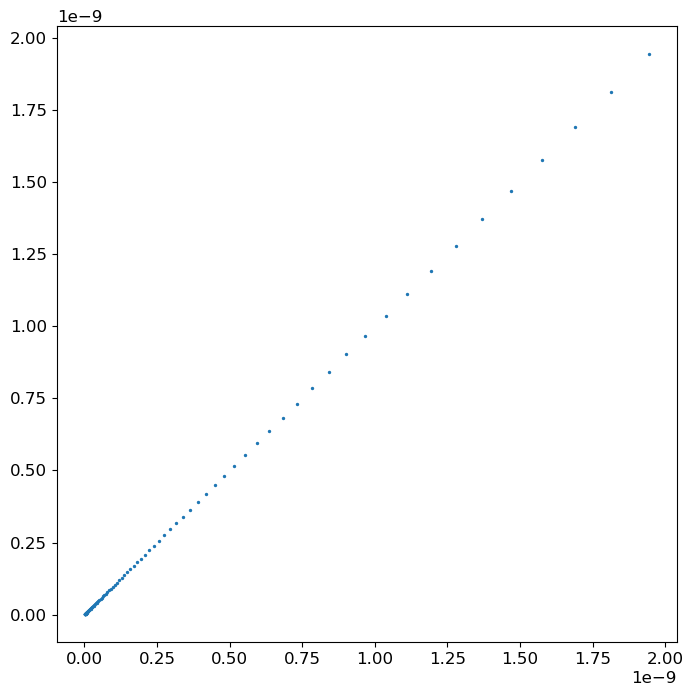

In [7]:
from shared.preface import *
import shared.functions as fct

Vs = 100

fig, ax = plt.subplots(1,1)

LOWER, UPPER = 0.01*T_CNB, 10*T_CNB

mom_lin = np.linspace(LOWER, UPPER, Vs)/T_CNB
# ax.scatter(mom_lin, mom_lin+10, s=2)

mom_geo = np.geomspace(LOWER, UPPER, Vs)/T_CNB
# ax.scatter(mom_geo, mom_geo, s=2)

v_geo = mom_geo / NU_MASS / (kpc/s)
# v_geo = 1/np.sqrt(NU_MASS**2/mom_lin**2 + 1) / (km/s)
ax.scatter(v_geo, v_geo, s=2)

plt.show()

### Conversions between momentum to velocity.

In [ ]:
NU_MASSES = np.array([0.01, 0.05, 0.1, 0.3])*eV
Vs = 100
LOWER = 0.01*T_CNB
UPPER = 400*T_CNB

# Momentum range.
MOMENTA = np.geomspace(LOWER, UPPER, Vs)

# Without Lorentz factor.
v_mins = np.zeros(len(NU_MASSES))
v_maxs = np.zeros(len(NU_MASSES))
for i, m_nu in enumerate(NU_MASSES):
    v_km = MOMENTA / m_nu / (m/s)
    v_min, v_max = v_km[0], v_km[-1]
    print(f'(m/s) -> v_min = {v_min:.2f}, v_max = {v_max:.2f}, %c = {v_max/const.c.value*100:.2f} : for {m_nu} eV neutrino')

    v_mins[i] = v_min
    v_maxs[i] = v_max

# for m_nu in NU_MASSES:

# With Lorentz factor.
v_mins = np.zeros(len(NU_MASSES))
v_maxs = np.zeros(len(NU_MASSES))
for m_nu in NU_MASSES:
    v_km = 1/np.sqrt(m_nu**2/MOMENTA**2 + 1) / (m/s)
    v_min, v_max = v_km[0], v_km[-1]
    print(f'(m/s) -> v_min = {v_min:.2f}, v_max = {v_max:.2f}, %c = {v_max/const.c.value*100:.2f} : for {m_nu} eV neutrino')

#! Since the sim is using 0.3 eV mass, the max. velocity present in the sim is 
#! ~20% of c, not the ~98% of the 0.01 eV neutrino (see output of cell).

# Back to momentum to check formulas & functions.

### Coordinates of Andromeda (AG) and the Virgo Cluster (VC).

In [ ]:
# Cross-check with values in Mertsch et al. (2020).
# -> x and y coords. are switched, since our setup is different,
# and my x (their y) coords. differ by 8.5 kpc due to placement of sun
# on our x-axis.
coords_VC = fct.halo_pos(GLAT_VC, GLON_VC, DIST_VC/kpc)
print(coords_VC, 'in kpc')
coords_AG = fct.halo_pos(GLAT_AG, GLON_AG, DIST_AG/kpc)
print(coords_AG, 'in kpc')

### Values in Table 1 of Mertsch et al. (2020).

In [ ]:
Rvir_Tab1 = fct.R_vir_fct(0, Mvir_MW)
print(Rvir_Tab1/kpc)
c_vir_Tab1 = fct.c_vir(0, Mvir_MW, Rvir_MW, Rs_MW)
Rs_Tab1 = Rvir_Tab1 / c_vir_Tab1
print(Rs_Tab1/kpc)

### Critical density of universe.

In [ ]:
rho_crit_today = fct.rho_crit(0)
print(f'{rho_crit_today*(Msun/kpc**3)/(kg/m**3):.2e} kg/m^3') 

### Time Variable s(z) and comparison to age of universe.

In [ ]:
# In s_of_z function we use
H0_mod = H0/ (1/s)
print(H0_mod)

test_z = 1
s_val = fct.s_of_z(test_z)
print(f'Value of time variable s in seconds at redhshift {test_z}:','\n', s_val)
print(
    'Age of universe comparison: \n', 
    f'"Observed/measured": {t0/s:.2e}, i.e. {t0/Gyr:.2f} Gyr \n', 
    f'What we use in s_of_z function: {1/H0/s:.2e}, i.e. {1/H0/Gyr:.2f} Gyr'
)

### Integrals for cosmic time.

In [ ]:
def t_integrand_a(a):

    # We need value of H0 in units of 1/s.
    H0_val = H0/(1/s)

    a_dot = np.sqrt(Omega_M/a**3 + Omega_L)*H0_val*a
    t_int = 1./a_dot

    return t_int

t, err = quad(t_integrand_a, 0, 1)
t_uni, err_uni = t, err
print(t_uni*s/Gyr, err_uni*s/Gyr)

In [ ]:
def t_integrand_z(z):

    # We need value of H0 in units of 1/s.
    H0_val = H0/(1/s)

    a_dot = np.sqrt(Omega_M*(1.+z)**3 + Omega_L)*H0_val*(1.+z)
    t_int = 1./a_dot

    return t_int

t, err = quad(t_integrand_z, 0, np.inf)
t_uni, err_uni = t, err
print(t_uni*s/Gyr, err_uni*s/Gyr)

### Fermi-Dirac distribution.

In [ ]:
p_test_range = np.linspace(0.01, 10)*T_CNB
FD_range = fct.Fermi_Dirac(p_test_range)

plt.loglog(p_test_range/T_CNB, FD_range)
plt.show()

### Redshift array for integration steps.

In [ ]:
# Linear spacing.
# late_steps = 200
# early_steps = 100
# Z_START, Z_STOP, Z_AMOUNT = 0., 4., late_steps+early_steps
# z_late = np.linspace(0,1,late_steps)
# z_early = np.linspace(1.01,4,early_steps)
# ZEDS = np.concatenate((z_late, z_early))

# Logarithmic spacing.
Z_AMOUNT = 50
z_shift = 1e-1
ZEDS = np.geomspace(z_shift, 4.+z_shift, Z_AMOUNT) - z_shift

plt.scatter(ZEDS, ZEDS, s=1)
plt.scatter(ZEDS_SNAPSHOTS, ZEDS_SNAPSHOTS+0.1, s=1)
plt.show()
print(ZEDS[0:10], ZEDS[-1])

### NFW density profile fct.

In [ ]:
r_range = np.geomspace(1e-3, 100, 100)*kpc
NFW_vals = fct.NFW_profile(r_range, rho0_MW, Rs_MW)
plt.loglog(r_range/kpc, NFW_vals/(GeV/cm**3))

### Typical grav. potential gradient vectors in spher. symmetric simulation.

In [ ]:
z = 0

# For position of Sun/Earth.
x_i = X_SUN*kpc
grad_MW = fct.dPsi_dxi_NFW(x_i, z, rho0_MW, Mvir_MW, Rvir_MW, Rs_MW, 'MW')
grad_MW /= (kpc/s**2)
print('Position of Sun/Earth:')
print(grad_MW)
print(np.sqrt(np.sum(grad_MW**2)), '\n')

# For a position closer to the center of the halo.
x_i = np.array([0.01, 0, 0])*kpc
grad_MW = fct.dPsi_dxi_NFW(x_i, z, rho0_MW, Mvir_MW, Rvir_MW, Rs_MW, 'MW')
grad_MW /= (kpc/s**2)
print('Position close to center:')
print(grad_MW)
print(np.sqrt(np.sum(grad_MW**2)), '\n')

# For a position further away to the center of the halo.
x_i = np.array([333., 0, 0])*kpc
grad_MW = fct.dPsi_dxi_NFW(x_i, z, rho0_MW, Mvir_MW, Rvir_MW, Rs_MW, 'MW')
grad_MW /= (kpc/s**2)
print('Position at virial radius:')
print(grad_MW)
print(np.sqrt(np.sum(grad_MW**2)))